In [16]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "256") \
    .config("spark.sql.orc.columnarReaderBatchSize", "256") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/02 14:08:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Spellcheck Text Renderings (OCRs)

In [17]:
import os
import requests
from symspellpy import SymSpell, Verbosity
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F
import re
import pandas as pd # For Pandas UDF type hint

# Define paths for dictionary files
data_dir = "../data"
os.makedirs(data_dir, exist_ok=True)

dictionary_path = os.path.join(data_dir, "tmp", "frequency_dictionary_en_82_765.txt")

# URL for the dictionary
dict_url = "https://raw.githubusercontent.com/wolfgarbe/SymSpell/refs/heads/master/SymSpell/frequency_dictionary_en_82_765.txt"

def download_file(url, dest_path):
    if not os.path.exists(dest_path):
        print(f"Downloading {url} to {dest_path}...")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status() # Raise an exception for HTTP errors
            with open(dest_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print("Download complete.")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {url}: {e}")
            # Optionally, re-raise or handle as critical error
            raise
    else:
        print(f"{dest_path} already exists.")

try:
    download_file(dict_url, dictionary_path)

    # Add dictionary file to Spark context so it's available on workers
    spark.sparkContext.addFile(dictionary_path)
    print(f"Added {os.path.basename(dictionary_path)} to Spark context.")

    # Test dictionary loading on the driver side (optional)
    sym_spell_test = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
    if sym_spell_test.load_dictionary(dictionary_path, term_index=0, count_index=1):
        print("SymSpell dictionary loaded successfully for testing on driver.")
    else:
        print("Failed to load SymSpell dictionary for testing on driver.")

except Exception as e:
    print(f"An error occurred during dictionary setup: {e}")

../data/tmp/frequency_dictionary_en_82_765.txt already exists.
Added frequency_dictionary_en_82_765.txt to Spark context.
SymSpell dictionary loaded successfully for testing on driver.


In [18]:
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StructType, StructField, FloatType, ArrayType, StringType # Modified imports
from symspellpy import SymSpell, Verbosity # Ensure it's available for UDF context
import re
import os # For basename in UDF
import pandas as pd # For type hint pd.Series
from collections import Counter # Added import

# Get the basename of the dictionary file that was added to SparkFiles
# This ensures the UDF uses the correct path on worker nodes
# Note: dictionary_path is from the previous cell's scope. If running cells separately, ensure it's defined.
# For robustness in notebook execution, re-define or pass as argument if necessary.
# However, spark.sparkContext.addFile makes it findable by basename.
dictionary_filename = os.path.basename(dictionary_path) 

# Define the schema for the UDF's output
spellcheck_output_schema = StructType([
    StructField("ratio", FloatType(), True), # Nullable if dictionary load fails
    StructField("top_misspelled_words", ArrayType(StringType()), True) # Nullable, can be empty list
])

@pandas_udf(spellcheck_output_schema) 
def calculate_misspelled_ratio(texts: pd.Series) -> pd.DataFrame: # Return type hint changed
    # Initialize SymSpell inside the UDF
    # max_dictionary_edit_distance must be >= max_edit_distance used in lookup
    sym_spell = SymSpell(max_dictionary_edit_distance=1, prefix_length=7)
    
    # Import SparkFiles inside UDF to get path on worker
    from pyspark import SparkFiles # Lazy import for worker context
    local_dictionary_path = SparkFiles.get(dictionary_filename)
    
    output_ratios = []
    output_top_misspelled_lists = []

    if not os.path.exists(local_dictionary_path) or \
       not sym_spell.load_dictionary(local_dictionary_path, term_index=0, count_index=1):
        # If dictionary load fails on worker, return NaNs and empty lists
        for _ in range(len(texts)):
            output_ratios.append(float('nan'))
            output_top_misspelled_lists.append([])
        return pd.DataFrame({'ratio': output_ratios, 'top_misspelled_words': output_top_misspelled_lists})

    for text in texts:
        if pd.isna(text) or not isinstance(text, str) or not text.strip():
            output_ratios.append(0.0) # Treat empty/invalid text as having no misspellings
            output_top_misspelled_lists.append([])
            continue

        # Preprocessing: lowercase, keep only English letters and spaces, then split
        clean_text = re.sub(r'[^a-z\s]', '', str(text).lower())
        words = [word for word in clean_text.split() if word] 

        if not words:
            output_ratios.append(0.0) # No words to check
            output_top_misspelled_lists.append([])
            continue

        misspelled_count = 0
        current_document_misspelled_words = []
        for word in words:
            # max_edit_distance=1: try to find the word with at most 1 edit
            # Verbosity.TOP: return only the top suggestion
            # include_unknown=True: if word not found, it's returned itself with count 0
            suggestions = sym_spell.lookup(word, Verbosity.TOP, max_edit_distance=1, include_unknown=True)
            
            is_misspelled = False
            if not suggestions: # Should ideally not be hit with include_unknown=True
                is_misspelled = True
            else:
                top_suggestion = suggestions[0]
                if top_suggestion.term != word or top_suggestion.count == 0:
                    is_misspelled = True
            
            if is_misspelled:
                misspelled_count += 1
                current_document_misspelled_words.append(word)
        
        ratio = misspelled_count / len(words) if len(words) > 0 else 0.0
        output_ratios.append(ratio)

        if current_document_misspelled_words:
            top_10_misspelled = [item[0] for item in Counter(current_document_misspelled_words).most_common(10)]
            output_top_misspelled_lists.append(top_10_misspelled)
        else:
            output_top_misspelled_lists.append([])
        
    return pd.DataFrame({'ratio': output_ratios, 'top_misspelled_words': output_top_misspelled_lists})

In [22]:
from wc_simd.utility import spark_path

text_df = (
    spark.read.parquet(spark_path("../data/plain_text_rendering.parquet"))
    # .sample(False, 0.0005, seed=42)
    .sample(False, 0.05, seed=42)
)
works_df = spark.table("works")

works_in_text_df = (
    works_df
    .join(
        text_df,
        works_df.id == text_df.id,
        "inner"
    )
    .select(works_df["id"], works_df["languages"], text_df["text"])
)

# Extract the first language from the languages array
works_in_text_df_first_lang = works_in_text_df.withColumn(
    "first_language", F.col("languages")[0]["id"])

# For demonstration, take a small sample. Adjust sample size as needed.
# Spellchecking can be computationally intensive.
# Using a fraction of 0.0005 (0.05%) for initial testing.
# Increase fraction for more comprehensive analysis if performance allows.
sampled_text_df = works_in_text_df_first_lang.where(F.col("first_language") == "eng")

print(
    f"Processing approximately {
        sampled_text_df.count()} records for spellcheck analysis.")

Processing approximately 8241 records for spellcheck analysis.


In [ ]:
# Rename table sampled_text_df to sampled_text_df_half_pct
# spark.sql("ALTER TABLE sampled_text_df_05pct RENAME TO sampled_text_df_pt_05pct")

DataFrame[]

In [23]:
sampled_text_df.write.saveAsTable("sampled_text_df_5pct", mode="overwrite")

In [ ]:
sampled_text_df = spark.table("sampled_text_df_pt_05pct")
print(f"Total records to process: {sampled_text_df.count()}")

Total records to process: 96


In [24]:
sampled_text_df = spark.table("sampled_text_df_5pct")
print(f"Total records to process: {sampled_text_df.count()}")

Total records to process: 8241


In [ ]:
# spark.sql(
#    "ALTER TABLE df_with_spellcheck_sampled RENAME TO df_with_spellcheck_sampled_pt_05pct")

DataFrame[]

In [26]:
# Apply the UDF
# Ensure to select relevant columns and dropna for the column used in UDF if it can be null
# The UDF itself handles None/NaN for text, so direct application is fine.
df_with_spellcheck = sampled_text_df.withColumn("misspelled_ratio", calculate_misspelled_ratio(F.col("text")))

df_with_spellcheck.write.saveAsTable("df_with_spellcheck_sampled_5pct", mode="overwrite")

In [27]:

df_with_spellcheck = spark.table("df_with_spellcheck_sampled_5pct")

# Show some results, including cases that might be problematic
print("Sample results with misspelled ratio and top misspelled words:")
df_with_spellcheck.select("id", "text", "misspelled_ratio.ratio", "misspelled_ratio.top_misspelled_words").show(20, truncate=50)

Sample results with misspelled ratio and top misspelled words:
+--------+--------------------------------------------------+-----------+--------------------------------------------------+
|      id|                                              text|      ratio|                              top_misspelled_words|
+--------+--------------------------------------------------+-----------+--------------------------------------------------+
|ajbz5qtp|UNIVERSITY OF BRISTOL MEDICAL LIBRARY Digitized...| 0.12377158|[the, trye, o, mr, th, d, hardwicke, tryes, tli...|
|aqyxynky|6 c+/-j- THE HEALTH OF THE CITY OF LEICESTER DU...| 0.15385608|                  [the, o, y, m, d, h, u, c, x, g]|
|b43r37k9|jufjn, . WJLA A J& 3 CELEBRATED WORM MEDICINE, ...| 0.23416236|   [the, j, dr, s, c, mr, sc, r, waites, longlane]|
|b832vchv|bM-h-SS (z) \ ' SW\ q y-\ 1 PORT REPORT, 1955. ...| 0.13852587|     [the, b, deratting, e, j, tion, g, c, dph, l]|
|b8f77sh9|<* ADDRESS % CHESTER COUNTY CABINET OF natural ...| 

In [28]:
df_with_spellcheck_pd = df_with_spellcheck.select(
    "id", "first_language", "text", "misspelled_ratio.ratio",
    "misspelled_ratio.top_misspelled_words"
   ).toPandas()

df_with_spellcheck_pd.to_csv(
    "../data/tmp/text_with_spellcheck_eng_sample_5pct.csv",
    index=False
)

25/06/02 14:24:19 ERROR TaskSetManager: Total size of serialized results of 68 tasks (1028.0 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
25/06/02 14:24:19 ERROR TaskSetManager: Total size of serialized results of 69 tasks (1044.5 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
25/06/02 14:24:19 ERROR TaskSetManager: Total size of serialized results of 70 tasks (1054.7 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
25/06/02 14:24:19 ERROR TaskSetManager: Total size of serialized results of 71 tasks (1066.4 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
25/06/02 14:24:19 ERROR TaskSetManager: Total size of serialized results of 72 tasks (1078.5 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
25/06/02 14:24:19 ERROR TaskSetManager: Total size of serialized results of 73 tasks (1096.0 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
25/06/02 14:24:19 ERROR TaskSetManager: Total size of serialized results of 74 tas

Py4JJavaError: An error occurred while calling o147.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 68 tasks (1028.0 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)


In [29]:
df_with_spellcheck_pd = df_with_spellcheck.select(
    "id", "first_language", "misspelled_ratio.ratio",
    "misspelled_ratio.top_misspelled_words"
   ).toPandas()

df_with_spellcheck_pd.to_csv(
    "../data/tmp/text_with_spellcheck_eng_sample_5pct.csv",
    index=False
)

In [32]:
import pandas as pd

df_with_spellcheck_pd = pd.read_csv(
    # "../data/tmp/text_with_spellcheck_eng_sample.csv"
    "../data/tmp/text_with_spellcheck_eng_sample_5pct.csv"
)

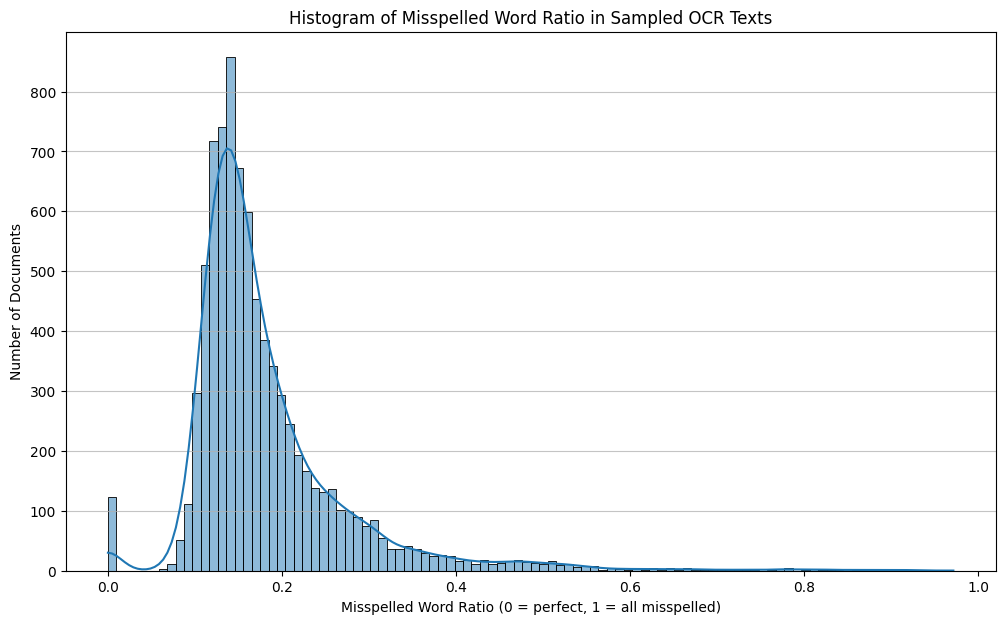


Descriptive statistics for misspelled_ratio:
count    8241.000000
mean        0.182608
std         0.096165
min         0.000000
1%          0.000000
5%          0.101861
25%         0.129297
50%         0.155689
75%         0.204380
95%         0.357787
99%         0.555933
max         0.971264
Name: ratio, dtype: float64


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Collect the misspelled_ratio for analysis
misspelled_ratios_pd = df_with_spellcheck_pd

plt.figure(figsize=(12, 7))
sns.histplot(misspelled_ratios_pd["ratio"], bins=100, kde=True) # Added KDE for smooth distribution
plt.title("Histogram of Misspelled Word Ratio in Sampled OCR Texts")
plt.xlabel("Misspelled Word Ratio (0 = perfect, 1 = all misspelled)")
plt.ylabel("Number of Documents")
plt.grid(axis='y', alpha=0.75)
plt.show()

# Print descriptive statistics
print("\nDescriptive statistics for misspelled_ratio:")
print(misspelled_ratios_pd["ratio"].describe(
    percentiles=[.01, .05, .25, .5, .75, .95, .99]))

In [34]:
df_with_spellcheck_pd

,id,first_language,ratio,top_misspelled_words
0,ajbz5qtp,eng,0.123772,"['the', 'trye', 'o', 'mr', 'th', 'd', 'hardwic..."
1,aqyxynky,eng,0.153856,"['the', 'o', 'y', 'm', 'd', 'h', 'u', 'c', 'x'..."
2,b43r37k9,eng,0.234162,"['the', 'j', 'dr', 's', 'c', 'mr', 'sc', 'r', ..."
3,b832vchv,eng,0.138526,"['the', 'b', 'deratting', 'e', 'j', 'tion', 'g..."
4,b8f77sh9,eng,0.173228,"['the', 'd', 'm', 'ot', 'w', 'h', 't', 'ed', '..."
...,...,...,...,...
8236,y3spkude,eng,0.138389,"['the', 'o', 'x', 'm', 'd', 'mr', 'c', 's', 'h..."
8237,z3xg73xt,eng,0.098128,"['the', 's', 'd', 'b', 'ee', 'ministrys', 'fe'..."
8238,z4f7husn,eng,0.511671,"['the', 'lo', 'o', 'od', 's', 'd', 'v', 'r', '..."
8239,z6r74vyw,eng,0.205635,"['the', 'ib', 'fome', 'difh', 'clofe', 'dith',..."


# Inspect Spellcheck Results

In [7]:
from wc_simd.utility import format_text


## 50% - Almost Half Pages are Landscape

In [8]:

print(format_text(df_with_spellcheck_pd.iloc[13].text))

â â â. â â â â â â¢> â â â â â â â â â â
â â â â â â â â â â *:â¦ <* â â â â â â â â
â â â â â â â â â â â â â â â â â â â
ââ BOROUGH OF GLOSSOP. â imapBnKiai EDUCATION COMMITTEE. Annual Report OF
THE School Medical Officer (E. H. Marcus Milligan, M.D., D.P.H.) FOR THE YEAR
1929. Gloasop Printers Limited, Telephone, 67. â â â <â¦ â â â â
â â¦ â â â <â¢ <â¦ <â¢ â â â â â â â â â â â
â â â â â â â â â â â â â â â â â â â â
â â â â â â â â â â â â â BOROUGH OF GLOSSOP.
EDUCATION COMMITTEE. Annual Report OF THE School Medical Officer (E. H. Marcus
Milligan, M.D., D.P.H.) FOR THE YEAR 1929. Glosaop Printers Limited, Telephone,
67. Digitized by the Internet Archive in 2017 with funding from Wellcome Library
https://archive.org/details/b29257906 Glossop Education A

## 30% - Medieval Type F → S

In [9]:

print(format_text(df_with_spellcheck_pd.iloc[16].text))

* Pe ; â : Ra sae F Â« . â Â» â a Co ! , { - ; Â£ : q : j Â¢ wk | i e -
&gt; oe i a, â oh re. . â oy Â» c t 7 â a â Ã© } â * ' wi Ny â * ak
4) â Fm ak rele ap iaAy ta * o. P: ee, * ar 4 4 nets â¢ 1/ q Ay ts 4 . ~ if
Pe % Z âPREVENTING DISEASES, | ANDRES TORING me fan tT Hp FOUNDED ON RATIONAL
PRINCIPLES, AND ADAPTED TO â âPERSONS OF EVERY CAPACITY. ae P ' Â¢ * cr 77
te - a te &gt; â â ~ r * 4 oP | fi Re By GEORGE WALLIS, MD. Se: M. S. |
EVITOR OF THE aa EDITION OF MOTHERBYâS MEDICAL ree . Facet a $Y DENHAMâs
WORKS, WITH rBone Bet, SCR SY os dad ot bad Fd ate A âas Say â ; PS , aes.
Oe hfe From Fa and Reafon. weour Practice. draw, ; KA ey ate: x âThe firmest
Bafis, and the foundeft Law,â -_ ms e i fs 4 eR âWhence Natureâ s powers i
in fulleft Vigour rife,â Papen : And dread Difeafe with all his Phalanx flies.
eee pele a te â(PRINTED eOr 7 ee On je AND. Is RovINsoN, PATERNOST#R-ROM, at :
â . I 4 âa 5S Bir â- = WY ae r se . $f =) . 

## < 10%

In [11]:

print(format_text(df_with_spellcheck_pd.iloc[60].text))

22102057625 Med K6209 * -V * THE MINDS AND MANNERS OF WILD ANIMALS BY WILLIAM T.
HORN AD AY THE MINDS AND MANNERS OF WILD ANIMALS CAMP FIRES ON DESERT AND LAVA
CAMP FIRES IN THE CANADIAN ROCKIES TAXIDERMY AND ZOOLOGICAL COLLECTING TWO YEARS
IN THE JUNGLE The Experiences of a Hunter and Naturalist in India, Ceylon, the
Malay Peninsula and Borneo. Illustrated. 8vo. THE AMERICAN NATURAL HISTORY A
Foundation of Useful Knowledge of the Higher Animals of North America. Four
Crown Octavo Volumes. Illustrated in colors and half-tones. THE SAME Royal 8vo.
Complete in one volume. OUR VANISHING WILD LIFE Its Extermination and
Preservation. CHARLES SCRIBNERâS SONS Digitized by the Internet Archive in
2017 with funding from Wellcome Library https://archive.org/details/b29820996
OVERPOWERING CURIOSITY OF A MOUNTAIN SHEEP This âlava ramâ stood thus on a
lava crest in the Pinacate Mountains for about twenty minutes, gazing spellbound
at two men and a pack mule. (See page 149) THE MINDS AND MANNE

## 37% - Charts + Landscape Charts

In [12]:

print(format_text(df_with_spellcheck_pd.iloc[89].text))

b.wt he WW he 6c Pan, bi pegee rr Sra pete hry as ere * Sib R oe See EES fT nd
Sd EP Me we 2F. nrrin as ; : OP tareâ . ar ge - â â 5 " palaces ae Ri
gioreten ha aetna Since een nee ee re ee : eae me itee Ae tM TE IR rl en es =
agra eas pernee heey aa Se chu IONE ana PE a ea pe igor eee Ef ee eae RE De fee
â anf FR data eg ge r - r os : ot ho ame â2 Ar ee. 6 gol 2 $s Pete ie
Memoraiudum by the Director-General, Army Medical Service, on the Transmission
of Enteric Fever by the â Chronic Carrier.â Presented to both Houses of
Parliament by Command of His Majesty. 7 And to be purchased, either directly or
through any Bookseller, from e? WYMAN AND SONS, Lrp., Ferrer Lang, E.C.; and 32,
ABINGDON STREET, WESTMINSTER, S.W.; or . OLIVER AND BOYD, TwEEDDALE Court,
EDINBURGH ; or Â¢ â i. PONSONBY, 116, Grarron STREET, DUBLIN. . 1909. _ [Cd.
4609.] Price, 1s. 9d. . 24 Gen. No. 1806 The Transmission of Enteric Fever by
the âChronic Carrier.â J.âINTRODUCTION. For many years the 

## 48% - Handwritten - Not supposed to OCR?

In [13]:

print(format_text(df_with_spellcheck_pd.iloc[91].text))

fe- Digitized by the Internet Archive in 2017 with funding from Wellcome Library
"Â»r https ://arch i ve. o rg/detai I s/b28905489 / â e-eyr^zi X. M <<ii ^ â
